In [606]:
import pandas as pd

import pandas as pd

import numpy as np
import seaborn as sns
import sys
import json
import ast

import matplotlib.image as mpimg
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from scipy.stats import norm

%load_ext autoreload

%autoreload 2

sys.path.append("../")
from protocols import utils

import warnings
warnings.filterwarnings(
    "ignore",
    category=RuntimeWarning,
    message="invalid value encountered in scalar divide",
)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [607]:
mutations = pd.read_csv('./data/MUTATIONS_BDQ.csv.gz').reset_index()

#read in the mutations tables, subsetted down to BDQ WHO-defined candidate genes
mutations = pd.read_csv('./data/MUTATIONS_BDQ.csv.gz').reset_index()
#GARC mutation naming
mutations["MUTATION"] = mutations.apply(
    lambda x: f"{x['GENE']}@{x['MINOR_MUTATION'] if x['IS_MINOR_ALLELE'] else x['MUTATION']}",
    axis=1,
)
#flag sysnonymous mutations
mutations["IS_SYNONYMOUS"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][0] == x.split("@")[-1][-1]
)
#flag null calls
mutations["IS_NULL"] = mutations["MUTATION"].apply(
    lambda x: x.split("@")[-1][-1]  == 'Z'
)
mutations["FRS"] = mutations.apply(
    lambda x: 1 if not x["IS_MINOR_ALLELE"] else x["FRS"], axis=1
)

#read in table of genomes
genomes = pd.read_csv("./data/GENOMES.csv.gz").reset_index()

#read in cyrptic samples
phenotypes_cryptic = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_CRYPTIC.csv.gz").reset_index()
phenotypes_cryptic_samples = set(phenotypes_cryptic.UNIQUEID)
#filter for high quality phenotypes from UKMYC5 and UKMYC6 plates
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.METHOD_3.isin(['UKMYC5','UKMYC6'])]
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.QUALITY=='HIGH']
phenotypes_cryptic = phenotypes_cryptic[phenotypes_cryptic.UNIQUEID.isin(genomes.UNIQUEID)]

assert phenotypes_cryptic.UNIQUEID.nunique() == len(phenotypes_cryptic.UNIQUEID), 'one or more samples have more than one DST measurement!'

#read in new nicd samples
phenotypes_nicd = pd.read_csv("./data/DST_MEASUREMENTS_BDQ_NICD.csv.gz").reset_index()
phenotypes_nicd_samples = set(phenotypes_nicd.UNIQUEID)
#filter for mgit samples
has_mgit = phenotypes_nicd[phenotypes_nicd.METHOD_CC=='WHO'].UNIQUEID
phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.UNIQUEID.isin(has_mgit)]
#filter for samples with genomes
phenotypes_nicd = phenotypes_nicd[phenotypes_nicd.UNIQUEID.isin(genomes.UNIQUEID)]
# for samples with more than one DST result this will return the resistant one if they disagree and the MIC if they agree
phenotypes_nicd = phenotypes_nicd.groupby("UNIQUEID").apply(utils.filter_multiple_phenos)

#combine cryptic and nicd phenotype tables
assert len(phenotypes_nicd_samples.intersection(phenotypes_cryptic_samples)) == 0, "data sets are not mutually exclusive!"
phenotypes = pd.concat([phenotypes_cryptic, phenotypes_nicd]) 
assert phenotypes.UNIQUEID.nunique() == len(phenotypes.UNIQUEID), 'one or more samples have more than one DST measurement!'

#read in growth data of the cryptic plates
growth = pd.read_csv("./data/UKMYC_GROWTH_BDQ.csv.gz")

samples = pd.merge(phenotypes, genomes, how='inner', on=['UNIQUEID'])[["UNIQUEID", "DRUG", "SOURCE", "METHOD_3", "PHENOTYPE", "METHOD_MIC", "METHOD_2"]]

all = pd.merge(mutations, samples, how='right', on=['UNIQUEID'])
all.dropna(subset=['METHOD_MIC'], inplace=True)
all['GENE'].fillna('None', inplace=True)


In [608]:
synonymous_mgit = []
synonymous_plate = []
wt_mgit = []
wt_plate = []

for i in all.UNIQUEID.unique():
    df = all[all.UNIQUEID == i]
    if df.METHOD_2.iloc[0] == 'MGIT':
        if len(df) == 1 and df.IS_SYNONYMOUS.iloc[0] == True:
            synonymous_mgit.append(df.UNIQUEID.iloc[0])
        elif pd.isna(df.MUTATION.iloc[0]):  
            wt_mgit.append(df.UNIQUEID.iloc[0])
    else:
        if len(df) == 1 and df.IS_SYNONYMOUS.iloc[0] == True:
            synonymous_plate.append(df.UNIQUEID.iloc[0])
        elif pd.isna(df.MUTATION.iloc[0]):
            wt_plate.append(df.UNIQUEID.iloc[0])

mgit_wts = all[all.UNIQUEID.isin(synonymous_mgit+wt_mgit)]
plate_wts = all[all.UNIQUEID.isin(synonymous_plate+wt_plate)]

mgit_mutants = all[(all.METHOD_2=='MGIT')&(~all.UNIQUEID.isin(synonymous_mgit+wt_mgit))]
plate_mutants = all[(all.METHOD_2=='microdilution plate')&(~all.UNIQUEID.isin(synonymous_plate+wt_plate))]

In [609]:
all[all.METHOD_2=='microdilution plate'].METHOD_MIC.value_counts()

0.03       7276
0.06       6391
0.015      2845
<=0.015    2840
<=0.008    1263
0.12       1076
0.25        458
0.5         158
1.0          40
>2           24
>1           12
2.0           6
Name: METHOD_MIC, dtype: int64

In [610]:
def process_mic_data(df):
    y_low = []
    y_high = []

    dilution_factor = 2
    tail_dilution_factor = dilution_factor ** 3 #3 doubling dilutions (or 3 log2MICs) censored extension on either side

    for mic in df['METHOD_MIC']:
        if mic.startswith('<='):
            lower_bound = float(mic[2:])
            y_low.append(lower_bound / tail_dilution_factor)  # Adjust for left-censoring
            y_high.append(lower_bound)
        elif mic.startswith('>'):
            upper_bound = float(mic[1:])
            y_low.append(upper_bound)
            y_high.append(upper_bound * tail_dilution_factor)  # Adjust for right-censoring
        else:
            # For exact MIC values, the interval is MIC - 1 doubling dilution
            mic_value = float(mic)
            y_low.append(mic_value / dilution_factor)
            y_high.append(mic_value)
            
    #return lower and upper bound arrays rounded to 3 decimal places
    return np.round(np.array(y_low), 3), np.round(np.array(y_high), 3)


#Interval regression:
    #We are trying to estimate parameters of a normal distribution (mu, sigma) 
    #need a log likelihood function to measure how likely observed data is given these parameters
    #we maximise this likelihood to regress the interval censored MICs to find best parameters

def log_likelihood(params, y_low, y_high):

    mu, sigma = params

    log_L = 0

    # likelihood function for left-censored values
    left_censored = np.isclose(y_low, -9.96578428) | np.isclose(y_low, -8.96578428)
    if np.any(left_censored):
        log_L += np.sum(norm.logcdf((y_high[left_censored] - mu) / sigma))

    # likelihood function for right-censored values
    right_censored = np.isclose(y_high, 2) | np.isclose(y_high, 3)
    if np.any(right_censored):
        log_L += np.sum(np.log(1 - norm.cdf((y_low[right_censored] - mu) / sigma)))

    # likelihood function for intervals
    interval_censored = ~left_censored & ~right_censored & (y_low != y_high)
    if np.any(interval_censored):
        log_L += np.sum(
            np.log(
                norm.cdf((y_high[interval_censored] - mu) / sigma)
                - norm.cdf((y_low[interval_censored] - mu) / sigma)
            )
        )
    return -log_L


In [611]:
#WT samples:

#convert MICs into intervals (lower and upper bounds)
y_low, y_high= process_mic_data(plate_wts)
#log transform upper and lower bound arrays
y_low_log = np.log2(y_low, where=(y_low > 0))
y_high_log = np.log2(y_high, where=(y_high > 0))
#generate initial gaussian parameters
initial_params = [np.mean(y_high_log), np.std(y_high_log)]
#minimise the log likelihood function 
result = minimize(log_likelihood, initial_params, args=(y_low_log, y_high_log), method='L-BFGS-B')
#fitted distributions mean and std
mu_hat, sigma_hat = result.x
#99th percentile =  (log(ecoff))
z_99 = mu_hat + 2.3263 * sigma_hat
#calculate ecoff (absolute)
ecoff = np.exp2(z_99)

In [612]:
print ('log2(ECOFF):', z_99)
print ('ECOFF:', ecoff)

log2(ECOFF): -1.9155282931414082
ECOFF: 0.26507485115950247


In [613]:
#Mutant samples:

#convert MICs into intervals (lower and upper bounds)
y_low_mutant, y_high_mutant= process_mic_data(plate_mutants)
#log transform upper and lower bound arrays
y_low_mutant_log = np.log2(y_low_mutant, where=(y_low_mutant > 0))
y_high_mutant_log = np.log2(y_high_mutant, where=(y_high_mutant > 0))
#generate initial gaussian parameters
initial_params = [np.mean(y_high_mutant_log), np.std(y_high_mutant_log)]
#minimise the log likelihood function 
result_mutant = minimize(log_likelihood, initial_params, args=(y_low_mutant_log, y_high_mutant_log), method='L-BFGS-B')
#fitted distributions mean and std
mu_hat_mutant, sigma_hat_mutant = result_mutant.x

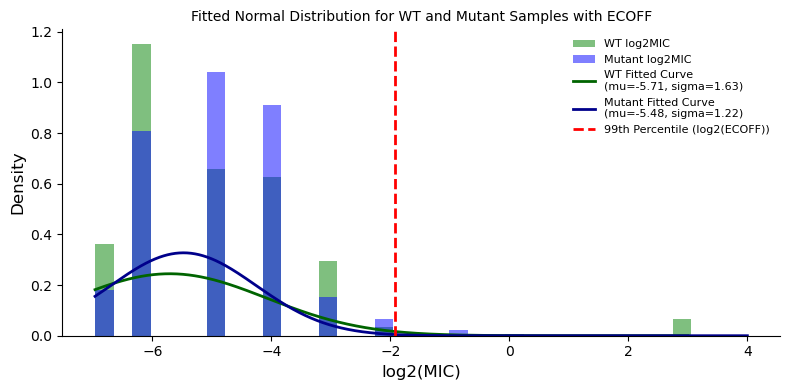

In [622]:
# Define common bin edges for both datasets - 
all_data = np.concatenate([y_high_log, y_high_mutant_log])
bins = np.linspace(min(all_data), max(all_data), 36)

plt.figure(figsize=(8, 4))
# plot the histogram of the WT and mutant log2MIC data
# to align the WT and mutant bars, set bins=bins (at the moment the density feature normalises the bars so sum(heights*width)=1)
plt.hist(y_high_log, bins=bins, density=True, alpha=0.5, color='green', label='WT log2MIC')
plt.hist(y_high_mutant_log, bins=bins, density=True, alpha=0.5, color='blue', label='Mutant log2MIC')
# create x values for the WT and mutant fitted normal distribution curves
wt_x_values = np.linspace(min(y_high_log), max(y_high_log), 1000)
mutant_x_values = np.linspace(min(y_high_mutant_log), max(y_high_mutant_log), 1000)
# calculate the fitted normal distribution curves
wt_fitted_curve = (1 / (sigma_hat * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((wt_x_values - mu_hat) / sigma_hat) ** 2)
mutant_fitted_curve = (1 / (sigma_hat_mutant * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((mutant_x_values - mu_hat_mutant) / sigma_hat_mutant) ** 2)
# plot the WT and mutant fitted curves
plt.plot(wt_x_values, wt_fitted_curve, color='darkgreen', linewidth=2, label=f'WT Fitted Curve\n(mu={mu_hat:.2f}, sigma={sigma_hat:.2f})')
plt.plot(mutant_x_values, mutant_fitted_curve, color='darkblue', linewidth=2, label=f'Mutant Fitted Curve\n(mu={mu_hat_mutant:.2f}, sigma={sigma_hat_mutant:.2f})')
# highlight the 99th percentile ECOFF
plt.axvline(x=z_99, color='red', linestyle='--', linewidth=2, label='99th Percentile (log2(ECOFF))')

plt.xlabel('log2(MIC)', fontsize=12)
plt.ylabel('Density', fontsize=12)
plt.title('Fitted Normal Distribution for WT and Mutant Samples with ECOFF', fontsize=10)
plt.legend(frameon=False, fontsize=8)
plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.tight_layout()
plt.show()

Our ECOFF remains the same as that published in the cryptic ecoff paper ~ 0.25.

Its interesting to note, very few mutant demonstrate elevated MICs on the plate - not resistant?

Mean of wts is higher than mutants - looks odd, but there are like 10000 mutant samples and < 10 WT, so...

Those wt samples on the far right are really annoying - wonder if i can justify getting rid of them? The bar is because we're plotting the higher bound of the interval, for the truncated bits which are not not on the plate. So don't be too misled by that bar the question is can we get rid of wt samples with v high MICs? Probs not

## To think about:
- 99th percentile of genetically WT distribution is simple and seems to work, but there are other options:
    - Claudio mentioned taking the lower 99th percentile of the non-WT population (assuming he meant phenotypic) - because we care about the non-WTs and some drugs have overlapping distributions
    - but, could also explore:
    -   Bayesian mixed model of MICs as a mixture of WT and non-WT distributions and use bayesian inference to estimate the most probably cutff point. This could return intervals within with the cutoff is likely to fall (as oppose to single percentile point), accounting for uncertainty
    - Could also think about ROC curve analysis - calculate tradeoff between sensitivty and specifcity bu considering different cutoff points and calculating TPR and FPR

- Should validate on other drugs - see what we get and compare to ecoff paper to make sure we've replicated sufficiently

Something to think about - when using interval regression for MIC classifications, one could convert those MIC labels to ternary labels using some threshold (ecoff or perhaps calculated each time?). If this was done dynamically, those that are S could be removed to proffer additional solos - or perhaps, even added to the wt samples to recalculate the threshold? What would the benefit of this be? Probs just overcomplicated and would shift wt mean right, making it harder to classify S - a table of identical MICs with different ternay labels would look very odd. 

Need to make sure Josh did in fact fit the ression model to solos... and if not, why not?

Also, remember although these are a tonne of samples - they are old plates ahdn thus for BDQ mostly S. The mgit samplesa re the really vaulable ones, but cant reclculate ecoff for that. Nor does it look like we can lower the ecoff for the plates.

So best to move on to interval ression. Can revist ecoff when binarising/ternarising MIC labels.

In [616]:
plate_wts.METHOD_MIC.unique()

array(['0.06', '<=0.015', '0.03', '0.12', '0.015', '<=0.008', '0.25',
       '>1'], dtype=object)